In [2]:
from TMP117 import TMP117
from MPU6050 import MPU6050
from TP import TP
from CAP11NA import CAP11NA
from BM1422 import BM1422
from plotAll import generateActiveList


In [3]:
import random
import numpy as np
from IPython.display import display, Image

In [4]:
duration = 700

# `Temperature Sensor Configurations`

(Parameters for TMP117 to be changed by teams)  

### `Continuous conversion (if selected) params`:
Continuous conversion mode: The device continuously performs temperature conversions in this mode, as shown in Table 7-7, and updates the temperature result register at the end of every active conversion. 
* Possible conversion cycle times (see Table 7-7 below): 0.0155, 0.125, 0.25, 0.5, 1, 4, 8, 16  
* Possible averaging inputs: 0, 8, 32, 64

### `One-Shot conversion (if selected) params`:
One-shot mode: After the device completes a (temperature conversion) one-shot conversion, the device goes to the low-power shutdown mode. 
* Possible conversion cycle times (first row of Table 7-7): 0.0155, 0.125, 0.5, 1 (conv cycle only consists of active time)
* Possible averaging inputs: 0, 8, 32, 64

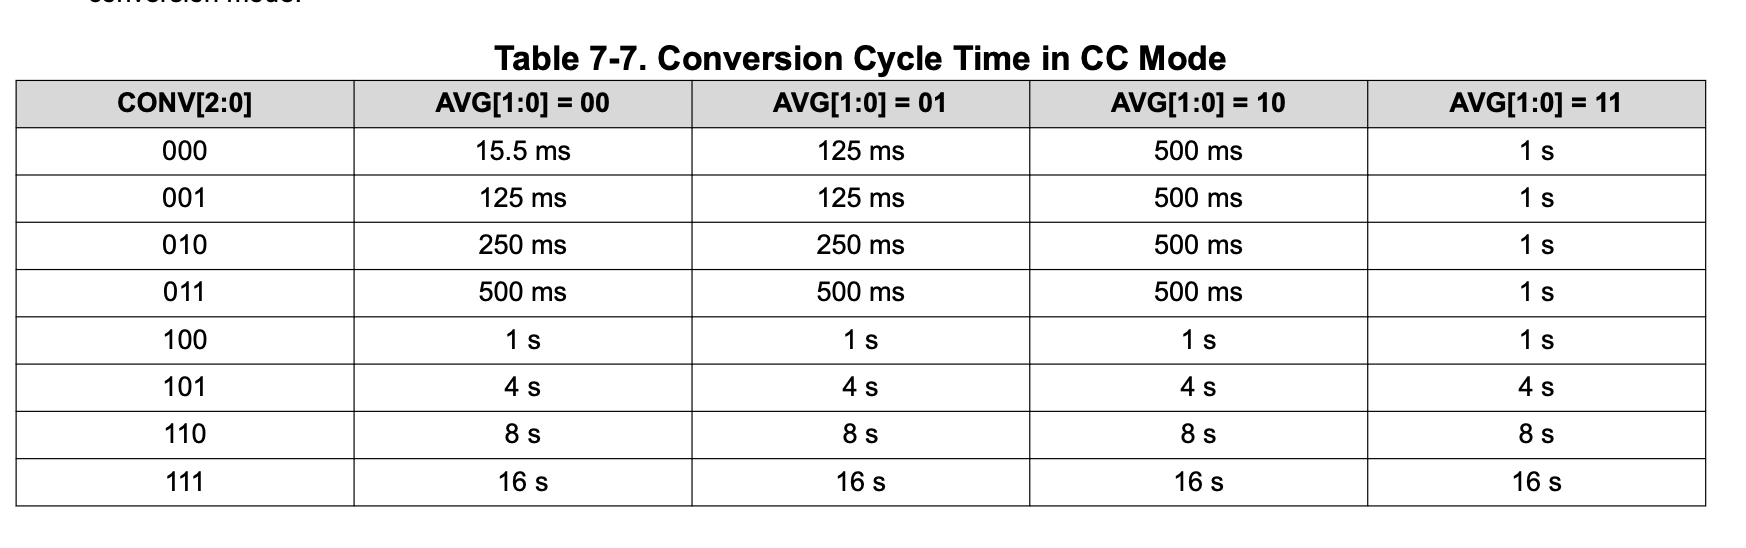

In [5]:
Image("convTimes.png")

#### TO-DO (teams set inputs)

In [6]:
time_step = 0.0155
duration = 100
activeTimeParams = [(0, 15, "OS_8_0.0155"), (30, 45, "CC_32_16"), (70, 75, "OS_64_16")]

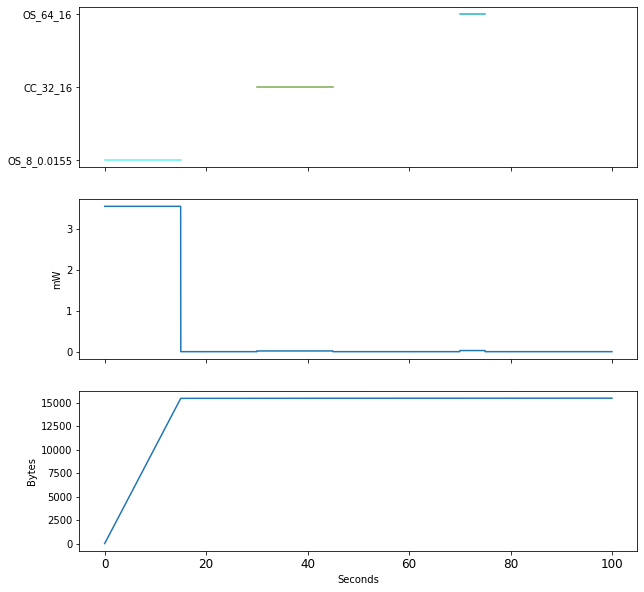

In [7]:
tmp1 = TMP117(time_step, duration, activeTimeParams) # creating TMP117 class
power_tmp, data_tmp, time = tmp1.Simulation()
tmp1.plotData(power_tmp, data_tmp, time, activeTimeParams)

In [14]:
modedict = {"OS_16_0.0155": 15, "CC_16_0.0155":30}
activeTimeParams = generateActiveList(duration, modedict=modedict)
tmp2 = TMP117(time_step, duration, activeTimeParams)
tmp2.Simulation();

# `Accelerometer Configurations`

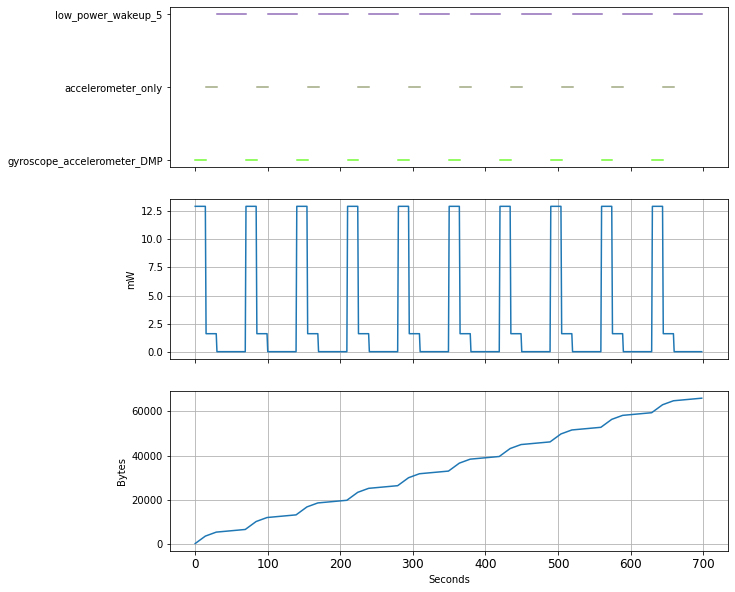

1

In [9]:
modedict = {"gyroscope_accelerometer_DMP":15, "accelerometer_only":15,"low_power_wakeup_5":40}
active_times = generateActiveList(total_time=699, modedict=modedict)
accel2 = MPU6050(time_step=1, duration=699, loop_rate=20, digital_low_pass=0, sample_rate_divisor=0)

accel2.runSim(active_times)

# `Thermopile Configurations`

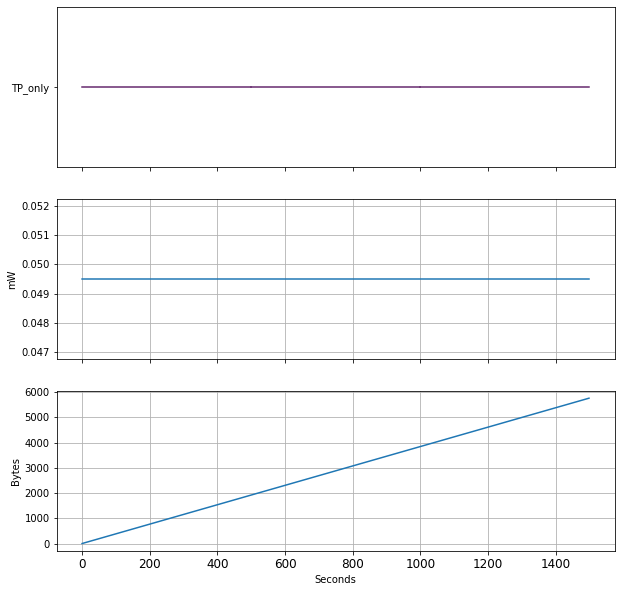

1

In [10]:
from TP import TP
Thermo = TP(time_step=1, duration=1500, loop_rate=20)
active_times = [(0,500,"TP_only"), (500,1000,"TP_only"), (1000,1500,"TP_only")]
Thermo.runSim(active_times)

# `Capacitor Configurations`

In [11]:
CAP11NA()

TypeError: __init__() missing 3 required positional arguments: 'loop_rate', 'duration', and 'time_step'

# `Magnetometer Configurations`

In [ ]:
BM1422()

In [ ]:
plotAll()
fig,ax = subplot()
